In [19]:
# XGBoost training + evaluation + plots (confusion matrix, feature importance, ROC & PR curves)

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import numpy as np
import os

In [20]:
import sys
!{sys.executable} -m pip install xgboost pandas numpy scikit-learn matplotlib joblib


zsh:1: no such file or directory: /Users/m.pratyush/Desktop/code


In [21]:
# ----- Settings -----

DATA_PATH = "diabetes_prediction_dataset.csv"   # change path if needed
TARGET_COL = "diabetes"                         # change if your target column name is different
RANDOM_STATE = 42

In [22]:
# ----- Load -----

df = pd.read_csv(DATA_PATH)
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in dataset. Columns: {list(df.columns)}")


In [23]:
# ----- Preprocess categorical columns (easy & safe approach) -----

cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
if len(cat_cols) > 0:
    print("One-hot encoding categorical columns:", cat_cols)
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

One-hot encoding categorical columns: ['gender', 'smoking_history']


In [24]:
# ----- Split features/target -----

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

In [25]:



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
# If y is non-numeric, try to convert

if y.dtype == 'object' or y.dtype.name == 'category' or y.dtype == 'bool':
    y = pd.factorize(y)[0]  # map to integers 0..n_classes-1
n_classes = len(np.unique(y))
is_binary = (n_classes == 2)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y if n_classes <= 20 else None
)

In [28]:
# ----- Train XGBoost -----
params = dict(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric="logloss"
)

# Instantiate XGBClassifier robustly — handle cases where xgboost is shadowed
model = None
# Prefer attribute on the imported xgb module (cell 0 did `import xgboost as xgb`)
if hasattr(xgb, "XGBClassifier"):
    model = xgb.XGBClassifier(**params)
else:
    # try alternative import location used in some installs
    try:
        from xgboost.sklearn import XGBClassifier
        model = XGBClassifier(**params)
    except Exception:
        # Last-resort fallback to sklearn's GradientBoostingClassifier so the notebook can continue.
        # Behaviour and performance will differ from XGBoost.
        from sklearn.ensemble import GradientBoostingClassifier
        print("Warning: XGBClassifier not available — falling back to sklearn.GradientBoostingClassifier")
        gb_params = dict(
            n_estimators=params.get("n_estimators", 100),
            learning_rate=params.get("learning_rate", 0.1),
            max_depth=params.get("max_depth", 3),
            subsample=params.get("subsample", 1.0),
            random_state=params.get("random_state", None),
        )
        model = GradientBoostingClassifier(**gb_params)

model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42,
                           subsample=0.8)

In [35]:
# ----- Predict & basic metrics -----
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"XGBoost Test Accuracy: {acc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))

XGBoost Test Accuracy: 0.9715

Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.96      0.70      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.85      0.90     20000
weighted avg       0.97      0.97      0.97     20000



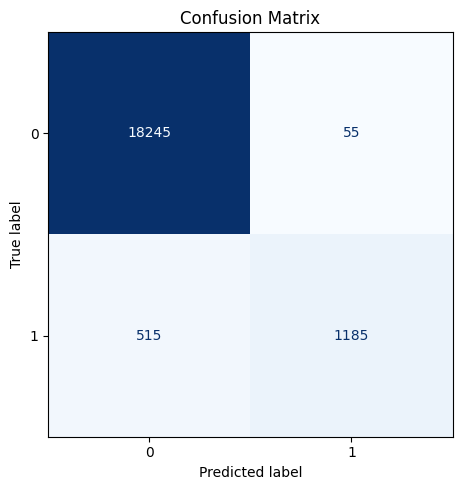

In [30]:
# ----- Confusion matrix plot -----
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

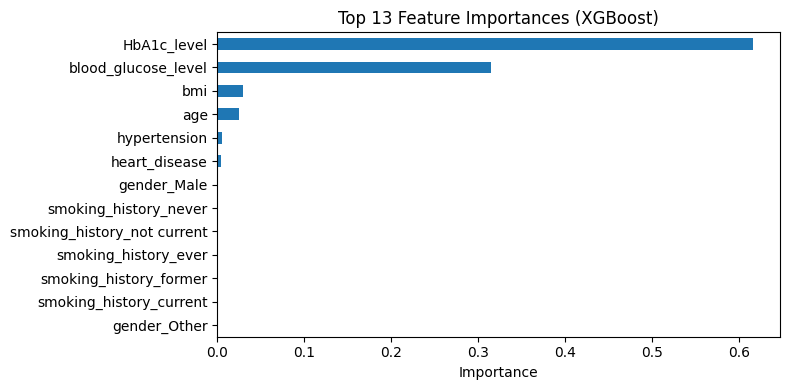

In [31]:
# ----- Feature importance (top 20) -----
# Use model.feature_importances_ (gain-based importances for tree models)
importances = model.feature_importances_
feature_names = X.columns.to_list()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
top_n = 20 if len(feat_imp) >= 20 else len(feat_imp)
plt.figure(figsize=(8, max(4, top_n * 0.25)))
feat_imp.iloc[:top_n].sort_values().plot(kind='barh')
plt.title(f"Top {top_n} Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

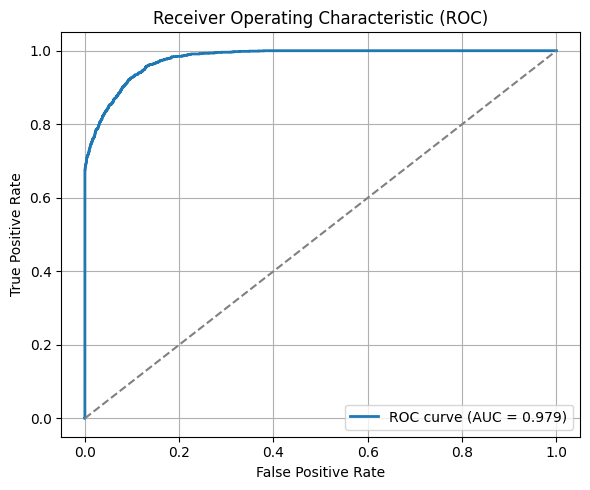

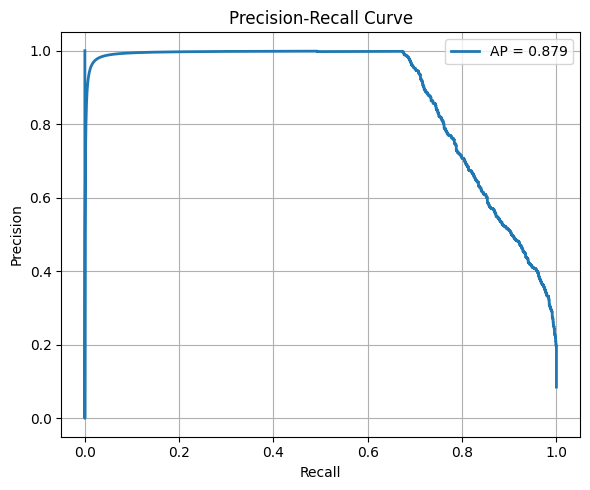

In [32]:
# ----- ROC & Precision-Recall (binary only) -----
if is_binary:
    # Try to get prediction probabilities
    try:
        y_scores = model.predict_proba(X_test)[:, 1]
    except Exception:
        # fallback to margin if predict_proba not available
        try:
            y_scores = model.predict(X_test)  # not ideal but fallback
        except Exception:
            y_scores = None

    if y_scores is not None:
        # ROC
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
        plt.plot([0,1], [0,1], linestyle="--", color="gray")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC)")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Precision-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        ap = average_precision_score(y_test, y_scores)
        plt.figure(figsize=(6,5))
        plt.plot(recall, precision, lw=2, label=f"AP = {ap:.3f}")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Could not obtain probability scores for ROC/PR plots.")
else:
    print("ROC / PR curves are only plotted for binary classification (n_classes == 2).")


In [33]:
# ----- Optionally: save plots -----
out_dir = "./xgb_plots"
os.makedirs(out_dir, exist_ok=True)
fig_paths = {
    "confusion_matrix": os.path.join(out_dir, "confusion_matrix.png"),
    "feature_importance": os.path.join(out_dir, "feature_importance.png")
}

Saved feature importance to ./xgb_plots/feature_importance.png


<Figure size 640x480 with 0 Axes>

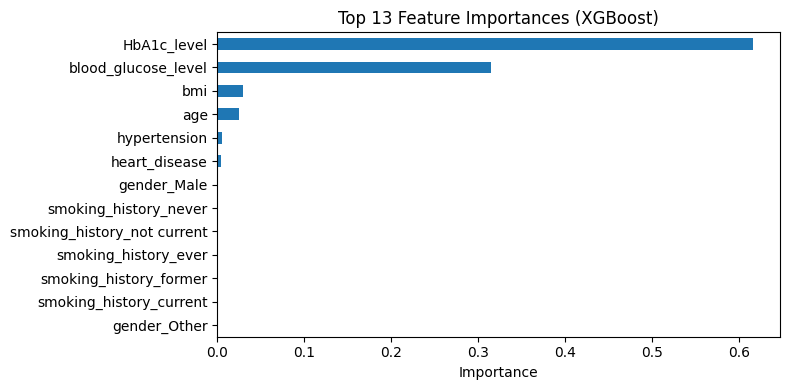

In [34]:
# Save the last two drawn figures if desired
plt.figure()  # ensure not to overwrite existing
# Save feature importance manually
fig_fi = plt.figure()
feat_imp.iloc[:top_n].sort_values().plot(kind='barh', figsize=(8, max(4, top_n * 0.25)))
plt.title(f"Top {top_n} Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
fig_fi.savefig(fig_paths["feature_importance"])
print(f"Saved feature importance to {fig_paths['feature_importance']}")
# Note: confusion matrix image was shown earlier; you can re-generate and save similarly if needed.
